<a href="https://colab.research.google.com/github/yoooobin/ESAA/blob/main/ESAA_YB_week5_1_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###03 _ 평가

머신러닝 모델의 성능 평가 지표(Evaluation Metric)

- 모델이 분류냐 회귀냐에 따라 여러 종류로 나뉨
- 회귀/ 실제값과 예측값의 오차 평균값에 기반
- 분류/ 정확도보다 다른 성능 평가 지표가 더 중요시됨

#### 01 정확도(Accuracy)

정확도(Accuracy) = $ \frac{\text{예측 결과가 동일한 데이터 건수}}{\text{전체 예측 데이터 건수}} $

- 정확도: 직관적으로 모델 예측 성능을 나타내는 평가 지표

In [85]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit( ) 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict( ) 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range (X.shape[0]):
            if X['Sex'].iloc[i] == 1:
               pred[i] = 0
            else :
               pred[i] = 1

        return pred

In [87]:
# Null 처리 함수
def fillna(df):
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Cabin'] = df['Cabin'].fillna('N')
    df['Embarked'] = df['Embarked'].fillna('N')
    df['Fare'] = df['Fare'].fillna(0)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
    return df

# 레이블 인코딩 수행.
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('/content/drive/MyDrive/ESAA/input/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df,
                                                  test_size=0.2, random_state=0)


# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


- 단순한 알고리즘으로 예측을 하더라고 데이터의 구성에 따라 정확도 결과가 높게 나올 수 있기 때문에 정확도를 평가 지표로 사용할 때는 매우 신중해야 함

In [89]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd


class MyFakeClassifier(BaseEstimator):
   def fit(self, x, y):
       pass

   # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
   def predict(self, X):
       return np.zeros((len(X), 1), dtype=bool)

# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [90]:
# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
Name: count, dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


- 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안됨
- 여러 가지 분류 지표와 함께 적용

#### 02 오차행렬

오차행렬(confusion matrix, 혼동행렬): 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지 함께 보여주는 지표
- 이진 분류의 예측 오류가 얼마인지 + 어떤 유형의 예측 오류가 발생하고 있는지
- 예측된 클래스 / 실제 클래스 값 기준으로 Negative, Positive 분류 => TN, FP, FN, TP
- TN: 에측값을 Negative 값 0으로 예측, 실제 값 역시 Negative 값 0
- FP: 에측값을 Positive 값 1으로 예측, 실제 값은 Negative 값 0
- FN: 에측값을 Negative 값 0으로 예측했으나, 실제 값 Positive 값 1
- TP: 에측값을 Positive 값 1으로 예측, 실제 값 역시 Positive 값 1


In [91]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

- TN: 405
- FP: 0
- FN: 45
- TP: 0

정확도 = 예측 결과와 실제 값이 동일한 건수/전체 데이터 수 = (TN + TP)/(TN + FP + FN + TP)

- 불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작아 데이터 기반 ML 알고리즘 Positive보다 Negative 예측 정확도가 높아지는 경향 => 분류 정확도 수치적 판단 오류

#### 03 정밀도와 재현율

- 정밀도 & 재현율: Positive 데이터 세트 예측 성능에 좀 더 초점을 맞춘 평가 지표
- 정밀도 = TP / (FP + TP) : 예측을 Positive로 한 대상 중 예측과 실제 값이 Positive로 일치한 데이터의 비율(양성 예측도)
- 재현율 = TP / (FN + TP): 실제 값이 Positive인 대상 중 예측과 실제 값이 Positive로 일치한 데이터의 비율(민감도)


- 정밀도<재현율 : 실제 Positive 양성 데이터를 Negative로 잘못 판단하여 업무상 큰 영향이 발생하는 경우
- 정밀도>재현율 : 실제 Negative 음성 데이터를 Positive로 잘못 판단하여 업무상 큰 영향이 발생하는 경우
- 가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치를 얻는 것

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:4f}, 재현율: {2:4f}'.format(accuracy, precision, recall))

In [93]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('/content/drive/MyDrive/ESAA/input/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                  test_size=0.2, random_state=11)
lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.824561, 재현율: 0.770492


**정밀도/재현율 트레이드오프**

정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류 결정 임곗값(Threshold) 조정해 정밀도 또는 재현율 수치 높일 수 있음
- 정밀도와 재현율은 상호 보완적 지표로 한 쪽 강제로 높이면 다른 하나 수치는 떨어짐 => 정밀도/재현율 트레이드 오프(Trade-off)
- predict_proba(): 학습이 완료된 사이킷런 Classifier 객체에서 호출 가능, 테스트 피처 데이터 세트를 파라미터로 입력해주면 테스트 피처 레코드 개별 클래스 예측 확률 결과 반환

In [94]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


- 분류 결정 임곗값을 조절해 정밀도와 재현율을 성능 수치를 상호 보완적으로 조정
- 사이킷런 Binarizer 클래스

In [95]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1, 2],
     [ 2,  0, 0],
     [ 0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


- Binarizer의 threshold 값이 1.1보다 같거나 작으면 0, 크면 1

In [96]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값, 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.824561, 재현율: 0.770492


- 앞 예제 타이타닉 데이터로 학습된 로지스틱 회귀 Classifier 객체에서 호출된 predict()로 계산된 지표 값과 정확히 같음

In [97]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.704225, 재현율: 0.819672


- 임곗값을 낮추니 재현율 값이 올라가고 정밀도가 떨어짐
- 분류 결정 임곗값은 Positive 예측값 결정 확률의 기준이 됨
- Positive 예측값이 많아지면 상대적으로 재현율 값이 높아짐 - 양성 예측을 많이 하다 보니 실제 양성을 음성으로 예측하는 횟수가 상대적으로 줄어들기 때문

In [98]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1,thresholds):
    # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.704225, 재현율: 0.819672

임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.786885, 재현율: 0.786885

임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.824561, 재현율: 0.770492

임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.865385, 재현율: 0.737705

임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.897959, 재현율: 0.721311


입력 파라미터 y_true: 실제 클래스값 배열 (배열 크기 = [데이터 건수])
입력 파라미터 probas_pred: Positive 칼럼 예측 확률 배열 (배열 크기 = [데이터 건수])
반환 값 정밀도: 임곗값별 정밀도 값을 배열로 반환
반환 값 재현율: 임곗값별 재현율 값을 배열로 반환

In [99]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(recalls[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값: [1.   1.   0.97 0.9  0.9  0.9  0.87 0.79 0.7  0.49 0.25]
샘플 임계값별 정밀도: [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율: [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


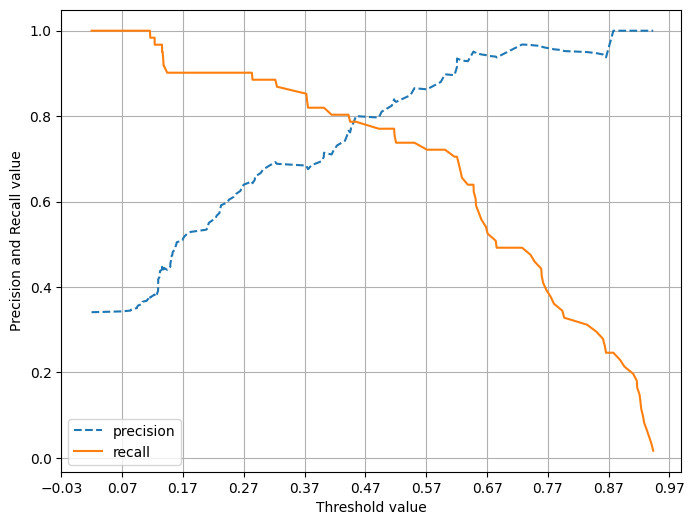

In [100]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현을 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.acorr

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

임곗값이 낮을수록 많은 수의 양성 예측으로 인해 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아짐

**정밀도와 재현율의 맹점**

임곗값의 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 하며 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용돼서는 안됨

*정밀도가 100%가 되는 방법*
- 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측

*재현율이 100%가 되는 방법*
- 모든 환자 Positive로 예측

####04 _ F1 스코어

F1 스코어(Score): 정밀도와 재현율 결합한 지표

$$
F1 = \frac{2}{\frac{1}{\text{recall}} + \frac{1}{\text{precision}}} = \frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$

In [101]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7966


In [134]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임곗값: 0.4
오차 행렬
[[80 20]
 [17 37]]
정확도:0.7597, 정밀도:0.6491, 재현율:0.6852, F1:0.6667

임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도:0.7857, 정밀도:0.7059, 재현율:0.6667, F1:0.6857

임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804

임곗값: 0.6
오차 행렬
[[91  9]
 [26 28]]
정확도:0.7727, 정밀도:0.7568, 재현율:0.5185, F1:0.6154


####05 _ ROC 곡선과 AUC

ROC 곡선, AUC 스코어: 이진 분류 예측 성능 측정에서 중요하게 사용되는 지표
- ROC(Receiver Operation Characteristic Curve): 수신자 판단 곡선 => FPR이 변할 때 TPR이 어떻게 변하는지 나타내는 곡선
- TTR(True Positive Rate): 민감도
- TNR(True Negative Rate): 특이성

FPR = FP / (FP+TN) = 1 - TNR = 1 - 특이성
- FPR을 0부터 1까지 변경하면서 TPR의 변화 값을 구함
- 분류 결정 임곗값은 Positive 예측값을 결정하는 확률 기준이기 때문에 FPR을 0으로 만들려면 임곗값을 1로 지정하면 됨
- TN을 0으로 만들고자 분류 결정 임곗값을 0으로 지정하면 FPR을 1로 만들 수 있음

In [103]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출한 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


- roc_curve() 결과: 임곘값이 1에 가까운 값에서 점점 작아지면서 FPR이 점점 커짐
- FPR이 조금씩 커질 때 TPR이 가파르게 커짐

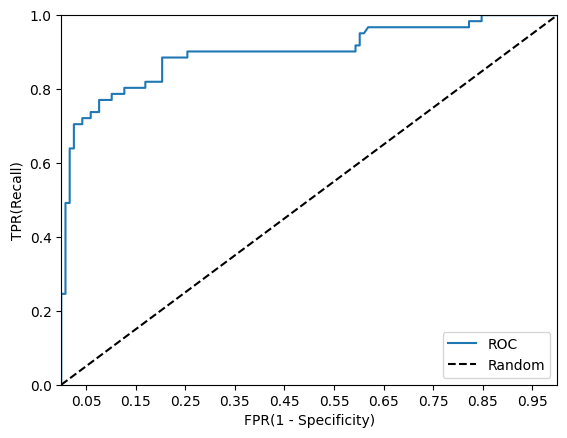

In [104]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1 - Specificity)'); plt.ylabel('TPR(Recall)')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

- AUC(Area Under Curve)값은 ROC 곡선 밑의 면적을 구한 것으로 1에 가까울수록 좋은 수치
- 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 면적이 1에 가까워지는 좋은 ROC AUC 성능 수치
- 보통의 분류는 0.5 이상의 AUC값

In [105]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8987


get_clf_eval() 함수: 정확도, 정밀도, 재현율, F1 스코어, ROC AUC값 출력 가능

In [137]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
        F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

#### 06 피마 인디언 당뇨병 예측

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('/content/drive/MyDrive/ESAA/input/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [108]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [126]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926,        F1: 0.6465, AUC:0.8083


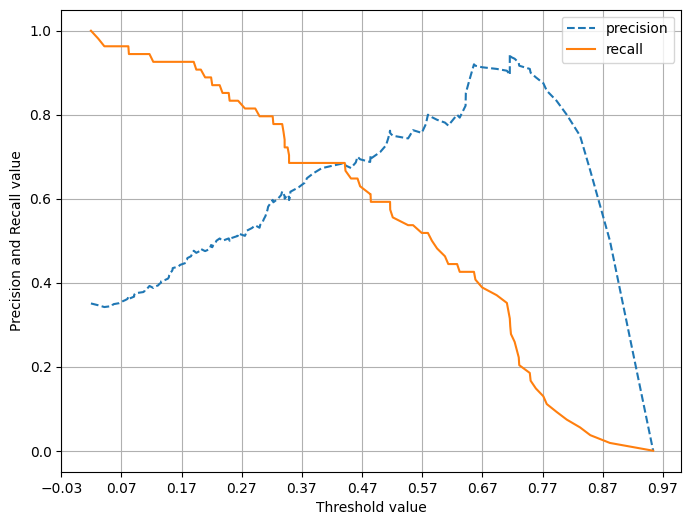

In [127]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

- 재현율 곡선을 보면 임곗값을 0.42 정도로 낮추면 정밀도와 재현율이 균형을 맞출 것 같음
- 두 지표 모두 0.7이 안되는 낮은 값

In [128]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


포도당 수치인데 min() 값이 0인 것이 말이 되지 않음

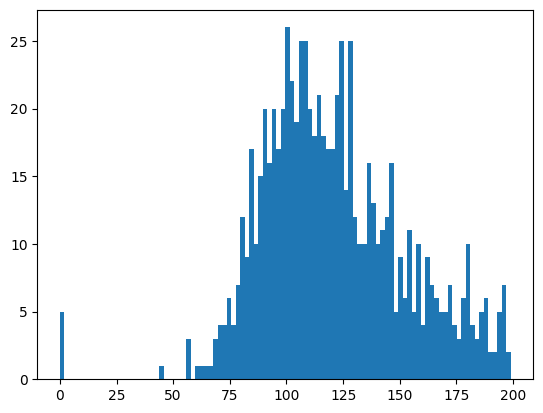

In [129]:
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show()

In [130]:
# 0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature, zero_count,
                                                       100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


In [131]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

0 값을 평균값으로 대체한 데이터 세트에 피처 스케일링 적용하여 변환

In [132]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,        F1: 0.6804, AUC:0.8433


데이터 변환과 스케일링으로 성능 수치가 일정 수준 개선됨

In [135]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.5]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도:0.7143, 정밀도:0.5658, 재현율:0.7963, F1:0.6615

임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도:0.7403, 정밀도:0.6000, 재현율:0.7778, F1:0.6774

임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도:0.7468, 정밀도:0.6190, 재현율:0.7222, F1:0.6667

임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도:0.7532, 정밀도:0.6333, 재현율:0.7037, F1:0.6667

임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도:0.7792, 정밀도:0.6923, 재현율:0.6667, F1:0.6792

임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도:0.7857, 정밀도:0.7059, 재현율:0.6667, F1:0.6857

임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481, F1:0.6931

임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804


In [138]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환.
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,        F1: 0.6931, AUC:0.8433


#### 07 정리

- 오차 행렬: Negative, Positive 값을 가지는 실제 클래스 값과 예측 클래스 값이 True, False에 따라 TN, FP, FN, TP로 매핑되는 4분면 행렬을 기반으로 예측 성능 평가
- 정밀도, 재현율: Positive 데이터 세트 예측 성능에 초점을 맞춘 평가 지표 >> 임곗값(threshold) 조정해 정밀도 또는 재현율 수치 높이기
- F1 스코어: 정밀도, 재현율 결합 평가 지표
- ROC-AUC: 이진 분류 성능 평가하기 위해 사용되는 지표, AUC값은 ROC 곡선 밑의 면적을 구한 것